# Network Visualization (PyTorch)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **PyTorch**; we have provided another notebook which explores the same concepts in TensorFlow. You only need to complete one of these two notebooks.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
from cvpr import *
from models.DownUp import * 
from models.ResNet import * 
from models.ResNet_Transfer import * 
from models.ResNet_Deconv import * 
from models.ResNet_Dilated import * 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

In [2]:
def preprocess(img, size=384):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [3]:
def create_optimizer(model, hp):
    
    optimizer = None
    if hp.optimizer == "Adam":    
        optimizer = torch.optim.Adam(model.parameters(), lr=hp.learning_rate, weight_decay=hp.weight_decay)
    if hp.optimizer == "AdaGrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=hp.learning_rate)
    if hp.optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=hp.learning_rate, weight_decay=hp.weight_decay, momentum=hp.momentum, nesterov=hp.use_Nesterov)
    if hp.optimizer == "RMSProp":
        optimizer = torch.optim.RMSProp(model.parameters(), lr=hp.learning_rate, weight_decay=hp.weight_decay, momentum=hp.momentum, eps=1e-10)
    
    return optimizer

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)


# Download and load the pretrained SqueezeNet model.
model = Resnet50_Transfer()
model = torch.nn.DataParallel(model).cuda()
optimizer = create_optimizer(model, hp)
load_checkpoint('saved_model__Resnet50_Transfer__11PM_June_07.pt', model, optimizer)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

model loaded from saved_model__Resnet50_Transfer__11PM_June_07.pt


## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

Loaded


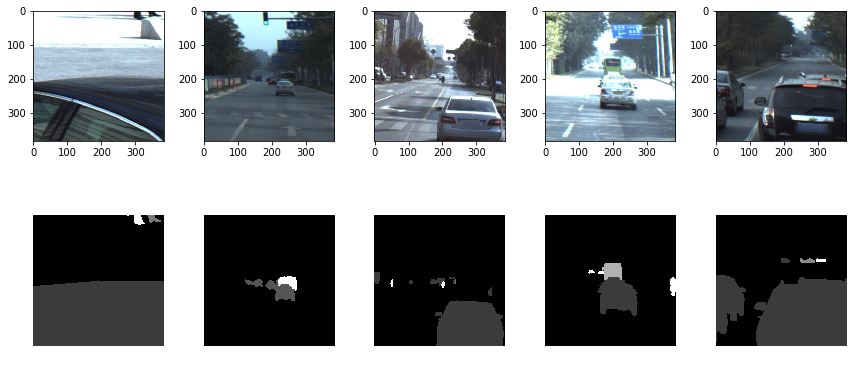

In [4]:
trainset = CVPR(hp, preload=False, transform=transforms.ToTensor(), train_sel = True)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=hp.batch_size, shuffle=True, num_workers=1)

print("Loaded")
for t, (x, y) in enumerate(trainset_loader):
    x = x.to(device='cuda', dtype=hp.dtype)  # move to device, e.g. GPU
    y = y.to(device='cuda', dtype=hp.dtype)
    y *= 255
    y[y == 255] = 0
    y = ConvertCELabels(y).cuda()
    

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    x_sq = x[i, :, :, :].squeeze()
    x_t = np.transpose(x_sq, (1, 2, 0))
    plt.imshow(x_t)
    plt.subplot(2, 5, 5 + i + 1)
    y_sq = y[i, :, :].squeeze()
    plt.imshow(y_sq)
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method
Recall in Assignment 1 you needed to select one element from each row of a matrix; if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [5]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[ 1.1845,  0.2343,  2.5786,  1.4711, -0.2687],
        [ 0.3294, -0.6055,  0.4007, -2.8297, -0.0681],
        [-1.0514, -1.6539,  0.1964,  0.0418, -0.5205],
        [-0.5087,  1.4929, -0.4567, -0.1931, -0.8948]])
tensor([ 1,  2,  1,  3])
tensor([ 0.2343,  0.4007, -1.6539, -0.1931])


In [6]:
def draw_bounding_box(box, x):
    im = x.clone().cpu()
    pad = 1
    xmin, xmax, ymin, ymax = box
    im[1, xmin:xmax, ymin-pad:ymin+pad] = 0
    im[1, xmin:xmax, ymax-pad:ymax+pad] = 0
    im[1, xmin-pad:xmin+pad, ymin:ymax] = 0
    im[1, xmax-pad:xmax+pad, ymin:ymax] = 0
    im[2, xmin:xmax, ymin-pad:ymin+pad] = 0
    im[2, xmin:xmax, ymax-pad:ymax+pad] = 0
    im[2, xmin-pad:xmin+pad, ymin:ymax] = 0
    im[2, xmax-pad:xmax+pad, ymin:ymax] = 0
    im[0, xmin:xmax, ymin-pad:ymin+pad] = 255
    im[0, xmin:xmax, ymax-pad:ymax+pad] = 255
    im[0, xmin-pad:xmin+pad, ymin:ymax] = 255
    im[0, xmax-pad:xmax+pad, ymin:ymax] = 255
    return im


def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    scores = model(X).cuda()
    
    if hp.loss_type == "full":
        loss_func = F.torch.nn.CrossEntropyLoss(reduce=False)
        loss = loss_func(scores, y)

    mask = torch.ones(loss.size(), device='cuda', dtype=hp.dtype)
    mask *= 0.05 #good results with 0.05
    bounding_box = []
    im = torch.zeros(X.shape, requires_grad=False)
    print(im.type())

    for n in range(y.shape[0]):
        indices = np.argwhere(y[n, :, :] > 0)
        if indices.numel() > 0:
            if indices.shape[1] >= 2:
                xmin = torch.min(indices[0, :]).item()
                ymin = torch.min(indices[1, :]).item()
                xmax = torch.max(indices[0, :]).item()
                ymax = torch.max(indices[1, :]).item()
                if xmin != xmax and ymin != ymax:
                    mask[n, xmin:xmax, ymin:ymax] = 1
                    bounding_box = (xmin, xmax, ymin, ymax)
#                     with torch.no_grad():
                    if xmin > 1 and ymin > 1 and xmax < 383 and ymax < 383:
                        im[n, :, :, :] = draw_bounding_box(bounding_box, X[n, :, :, :])

    N, H, W = loss.shape

    loss = torch.sum(torch.mul(loss, mask)) / (N * H * W)

    loss.backward()
    Xgrad = X.grad
    Xgrad = torch.abs(Xgrad)
    Xgrad = Xgrad.cpu()
    saliency, _ = torch.max(Xgrad, dim=1)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency, im

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

torch.FloatTensor


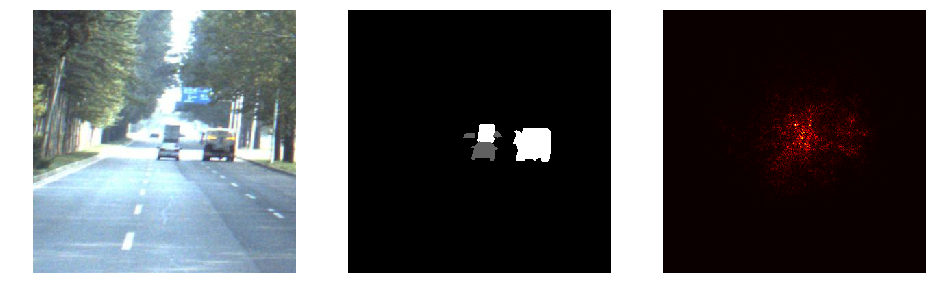

In [22]:
def show_saliency_maps(X, y):
    # Compute saliency maps for images in X
    saliency, im = compute_saliency_maps(X, y, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    X = X.cpu()
    y = y.cpu()
    X = X.detach().numpy()
    im = im.detach().numpy()
    y = y.detach().numpy()
    
    img = 14


    plt.subplot(1, 3, 1)
    x_sq = X[img, :, :, :].squeeze()
    x_t = np.transpose(x_sq, (1, 2, 0))
    plt.imshow(x_t)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    y_sq = y[img, :, :].squeeze()
    plt.imshow(y_sq)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(saliency[img], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(16, 5)
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()

show_saliency_maps(x, y)